In [1]:
import numpy as np 
import pandas as pd
from fastai.data_block import get_files
from fastprogress import master_bar, progress_bar
import tensorflow as tf
import torch 
import os
import pickle
import re
from collections import defaultdict

In [2]:
#%load_ext autoreload
#%autoreload 2
#os.environ["CUDA_VISIBLE_DEVICES"]="2"

from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight

In [3]:
from fastai import *
from fastai.basic_train import *
from fastai.basic_data import *
from fastai.data_block import *
from fastai.torch_core import *
from fastai.train import *
from fastai.callback import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.layers import *
from fastai.metrics import *

In [4]:
flatten = lambda l : [item for sublist in l for item in sublist]
def to_one_hot(v,c): return torch.zeros((c,)).scatter_(0,v,1.)

In [5]:
A_SZ, V_SZ, L_SZ = 128,1024, 300 #303
IN_PATH  = 'yt8m-processed'

files = sorted([str(f) for f in get_files(IN_PATH, '.pkl')])

In [6]:
d = dict()
for f in progress_bar(files):
    with open(f, 'rb') as handle:
        _d = pickle.load(handle)
    n = int(re.match(r'.*d(\d+)\.pkl', f)[1])
    fa= re.sub(r'd\d+\.pkl', f'a{n}.bin', f) 
    fv= re.sub(r'd\d+\.pkl', f'v{n}.bin', f) 
    d.update({k: (fa,fv,*v) for k, v in _d.items()})

In [7]:
# process dict to be:
# fname_audio, fname_video,start,len,[labels]+,[segment_start,[segment_label,segment_score,]+]+
fnames_a,fnames_v = set(), set()
val_labels = set()
for k,v in progress_bar(d.items()):
    if len(v) == 5:
        fa,fv,s,e,labels = v
        d[k] = fa,fv,s,e,labels,[]
    else:
        fa,fv,s,e,labels,segments = v
        sd = defaultdict(list)
        for segment in segments:
            s_l,s_s,s_ss,s_se = segment
            val_labels.add(s_l)
            assert s_se-s_ss == 5
            sd[s_ss].append((s_l,s_s))
        d[k] = fa,fv,s,e,labels,list(sd.items())
    fnames_a.add(fa)
    fnames_v.add(fv)
        

In [8]:
list(d.items())[-1]

('H5Ti',
 ('yt8m-processed/val_a0.bin',
  'yt8m-processed/val_v0.bin',
  10793610,
  300,
  [571],
  [(80, [(571, 1.0)]),
   (205, [(571, 1.0)]),
   (150, [(571, 0.0)]),
   (110, [(571, 1.0)]),
   (180, [(571, 1.0)])]))

In [9]:
val_labels_l = sorted(val_labels)
train_label_to_val = lambda x: val_labels_l.index(x)

i = 0
# filter items that DO NOT have val_labels, remove labels not in val_labels
# and re-reference labels from 0..1000 (using val_labels as index)
old_d = d.copy()
d = {}
for k,v in progress_bar(old_d.items()):
    fa,fv,s,e,labels,segments = v
    intersection = val_labels.intersection(labels)
    if len(intersection)!=0:
        new_labels = [train_label_to_val(label) for label in intersection]
        new_segments = []
        for s_s,s_ll in segments:
            new_segments.append((s_s, [(train_label_to_val(s_label),s_score) for s_label,s_score in s_ll]))
        d[k]= fa,fv,s,e,new_labels,new_segments

In [10]:
list(d.items())[-1]

('H5Ti',
 ('yt8m-processed/val_a0.bin',
  'yt8m-processed/val_v0.bin',
  10793610,
  300,
  [316],
  [(80, [(316, 1.0)]),
   (205, [(316, 1.0)]),
   (150, [(316, 0.0)]),
   (110, [(316, 1.0)]),
   (180, [(316, 1.0)])]))

In [11]:
all_labels = flatten([v[4] for v in d.values()])

In [12]:
#N_V_LABELS = len(np.unique([item for sublist in [v[4] for v in d.values()] for item in sublist]))
N_V_LABELS = 1000 # video labels in val_labels

In [13]:
label_weights = Tensor(compute_class_weight('balanced', range(N_V_LABELS), all_labels))

In [14]:
def mmap_bytetensor(f, shape, shared=False,size=None):
    return torch.ByteTensor(torch.ByteStorage.from_file(
        f, shared=shared, size=size if size is not None else os.path.getsize(f))).view(*shape)

In [15]:
class YTItem(ItemBase):
    a = {fa: mmap_bytetensor(fa, (-1,A_SZ)) for fa in fnames_a}
    v = {fv: mmap_bytetensor(fv, (-1,V_SZ)) for fv in fnames_v} 
    
    def __init__(self,i): 
        self.i = i

    @property
    def data(self):
        vid, (fname_a,fname_v,idx,l,classes,segments) = self.i
        a = torch.zeros((L_SZ,A_SZ), dtype=torch.float32) # audio
        v = torch.zeros((L_SZ,V_SZ), dtype=torch.float32) # video  
        m = torch.zeros((L_SZ,),     dtype=torch.bool)    # mask
        l = min(min(idx+l, YTItem.a[fname_a].shape[0]) - idx, L_SZ)
        #l = l // 5 * 5 # multiple of 5
        a[:l] = (YTItem.a[fname_a][idx:idx+l].to(dtype=torch.float32))/255 - 0.5
        v[:l] = (YTItem.v[fname_v][idx:idx+l].to(dtype=torch.float32))/255 - 0.5
        m[l:] = True
        return a,v,m,l
        
    def __str__(self):
        # TODO: count n_atoms correctly. 
        return f'{self.i}'
    
    def apply_tfms(self, tfms:Collection, **kwargs):
        x = self.clone()
        for t in tfms:
            if t: x.data = t(x.data)
        return x
    
    def clone(self):
        return self.__class__(self.i)

In [16]:
class YTLabel(ItemBase):
    def __init__(self,labels,segments,**kwargs): 
        self.labels, self.segments = labels,segments
        if len(segments):
            lll = flatten([[(o,label,score) for label,score in l ]for (o,l) in segments])
            i = torch.LongTensor([(o//5, c)for (o,c,_) in lll])
            v = torch.Tensor([s+1 for (_,_,s) in lll]) # 0,1 => 1,2
            self.t_segments = torch.sparse.FloatTensor(i.t(), v, torch.Size([1+L_SZ//5,N_V_LABELS]))
        else:
            self.t_segments = torch.sparse.FloatTensor(torch.LongTensor([[L_SZ//5,0]]).t(), 
                                                  torch.Tensor([1]),torch.Size([1+L_SZ//5,N_V_LABELS]))
        self.t_labels = LongTensor(self.labels)
    @property
    def data(self):
#        return to_one_hot(self.t_labels, N_V_LABELS),self.t_segments.to_dense()
        return to_one_hot(self.t_labels, N_V_LABELS)#,self.t_segments.to_dense()
    def __str__(self):
        return f'{self.labels}, {self.segments}'
    def apply_tfms(self, tfms:Collection, **kwargs):
        y = self.clone()
        for t in tfms:
            if t: y.data = t(y.data)
        return y
    def clone(self): return self.__class__(self.labels, self.segment)
    def __hash__(self): return hash(str(self))
    
class YTLabelList(ItemList):
    def __init__(self, items:Iterator, **kwargs):
        super().__init__(items, **kwargs)

    def get(self, i):
        o = super().get(i)
        return YTLabel(*o)

    def reconstruct(self,t): return 0; # TODO for viz !!!! ScalarCouplingItem(t.numpy())

In [17]:
data = ItemList(items=(YTItem(i) for i in d.items()),label_cls=YTLabel).split_by_rand_pct(0.2, seed=45)

In [18]:
t = YTLabel(data.train[2097294-418].i[1][4],data.train[2097294-418].i[1][5]).data

In [19]:
t

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [20]:
lll = flatten([[(o,label,score) for label,score in l ]for (o,l) in data.train[2097294-31110].i[1][5]])
i = torch.LongTensor([(o//5, c)for (o,c,_) in lll])
v = torch.Tensor([s+1 for (_,_,s) in lll])
torch.sparse.FloatTensor(i.t(), v, torch.Size([L_SZ//5,N_V_LABELS])).to_dense()[32]-1


tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -

In [21]:
i

tensor([[  7, 164],
        [ 21, 164],
        [  6, 164],
        [ 13, 164],
        [ 16, 164]])

In [22]:
data.label_from_func(lambda x: x.i[1][4:],label_cls=YTLabelList)

LabelLists;

Train: LabelList (2097294 items)
x: ItemList
('sCyE', ('yt8m-processed/a0.bin', 'yt8m-processed/v0.bin', 600, 251, [4], [])),('8gyE', ('yt8m-processed/a0.bin', 'yt8m-processed/v0.bin', 851, 258, [2, 0], [])),('N6yE', ('yt8m-processed/a0.bin', 'yt8m-processed/v0.bin', 1409, 290, [13], [])),('yDyE', ('yt8m-processed/a0.bin', 'yt8m-processed/v0.bin', 1956, 300, [15, 0, 11], [])),('9ryE', ('yt8m-processed/a0.bin', 'yt8m-processed/v0.bin', 2506, 173, [22, 59], []))
y: YTLabelList
[4], [],[2, 0], [],[13], [],[15, 0, 11], [],[22, 59], []
Path: .;

Valid: LabelList (524323 items)
x: ItemList
('n5DH', ('yt8m-processed/a74.bin', 'yt8m-processed/v74.bin', 9047287, 208, [6, 188], [])),('w3vF', ('yt8m-processed/a1.bin', 'yt8m-processed/v1.bin', 6062249, 162, [14, 3, 192, 9, 56], [])),('RrOe', ('yt8m-processed/a19.bin', 'yt8m-processed/v19.bin', 5969173, 162, [32], [])),('yi0X', ('yt8m-processed/a23.bin', 'yt8m-processed/v23.bin', 3728527, 150, [448], [])),('m823', ('yt8m-processed/a23.

In [23]:
data = data.databunch()

In [24]:
class DummyDecoder(Module):
    def __init__(self,dropout:float=0):
        self.dropout = nn.Dropout(dropout)

    def forward(self,tgt, memory, tgt_mask=None, memory_mask=None, 
                tgt_key_padding_mask=None, memory_key_padding_mask=None):
        return self.dropout(memory)
    
class PositionalEncoding(Module):
    "Encode the position with a sinusoid."
    def __init__(self, d:int): self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))

    def forward(self, pos:Tensor):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc
    
class YTTransformer(Module):
    def __init__(self,n_layers,n_heads,d_model,embed_p:float=0,final_p:float=0,d_head=None,deep_decoder=False,
                 dense_out=False,recurrent_decoder=False, pos=True, use_audio=True, **kwargs):
        
        self.use_audio = use_audio
        self.d_av = (V_SZ + A_SZ) if self.use_audio else V_SZ
        self.d_model = d_model
        self.pos = pos
        self.recurrent_decoder = recurrent_decoder
        d_head = ifnone(d_head, d_model//n_heads)
        self.pre_encoder = nn.Linear(self.d_av, d_model)

        self.transformer = nn.Transformer(num_encoder_layers=n_layers,
                                          nhead=n_heads,d_model=d_model,dim_feedforward=d_inner,
                                          dropout = 0., custom_decoder=DummyDecoder(dropout=0.))
    
        self.pos_enc = PositionalEncoding(d_model) if self.pos else nn.Embedding(L_SZ//5*5, d_model)

        if recurrent_decoder:
            self.rnn = torch.nn.GRU(d_model, N_V_LABELS)
        else:
            self.label_pool0   = nn.AdaptiveAvgPool1d(1)
            self.label_pool1   = nn.AdaptiveMaxPool1d(1)
            self.label_decoder = nn.Linear(d_model*2, N_V_LABELS)

        self.segment_pool    = nn.AdaptiveAvgPool1d(L_SZ//5)
        self.segment_decoder = nn.Conv1d(d_model, N_V_LABELS,1)
    
        
    def forward(self,a,v,m,l):
        bs,l_v,c_v = v.shape
        pos = torch.arange(0, L_SZ//5*5, device=v.device, dtype=v.dtype if self.pos else torch.int64)
        if self.use_audio: 
            x = torch.cat([v,a], dim=-1)
        else:
            x = v
        x = self.pre_encoder(x)
        x = (x + self.pos_enc(pos)[None]) * math.sqrt(self.d_model)
        x.masked_fill_(m.unsqueeze(-1), 0.)
        x = x.transpose(0,1)
        x = self.transformer(x, x, src_key_padding_mask=None)
        if self.recurrent_decoder:
            self.rnn.flatten_parameters()
            output,labels = self.rnn(x) # 
            labels = labels.permute(1,2,0).squeeze(-1) # (S, N, H_{out})
            x = x.permute(1,2,0)
        else:
            x = x.permute(1,2,0)
            labels = x[:,:,0]
#            labels = torch.cat((self.label_pool0(x),self.label_pool1(x)),dim=1).squeeze(-1)
#            labels = self.label_decoder(labels)
        segments = self.segment_pool(x).squeeze(-1)
        segments = self.segment_decoder(segments).squeeze(-1)
        
        return labels#,segments
    
    def reset(self): pass

In [25]:
class MaskedLoss(Module):
    def __init__(self):
        self.loss = torch.nn.BCEWithLogitsLoss(pos_weight=label_weights.cuda())

    def forward(self, from_forward, t_labels):#, t_segments):
        #p_labels,p_segments= from_forward        
        p_labels= from_forward        
        return self.loss(p_labels,t_labels)

In [26]:
torch.manual_seed(0)
net, learner = None,None
gc.collect()
torch.cuda.empty_cache()

n_layers=8
n_heads=10
d_model=N_V_LABELS # V_SZ+A_SZ
d_inner=2048

deep_decoder = False
dense_out = False

net = YTTransformer(n_layers=n_layers, n_heads=n_heads,d_model=d_model,d_inner=d_inner,
                      resid_p=0., attn_p=0., ff_p=0., embed_p=0, final_p=0.,
                      deep_decoder=deep_decoder, dense_out=dense_out, recurrent_decoder=False)

learner = Learner(data,net,loss_func=MaskedLoss()).to_fp32()

In [27]:
learner.summary()

YTTransformer
Layer (type)         Output Shape         Param #    Trainable 
Linear               [300, 1000]          1,153,000  True      
______________________________________________________________________
Linear               [1, 2048]            2,050,048  True      
______________________________________________________________________
Dropout              [1, 2048]            0          False     
______________________________________________________________________
Linear               [1, 1000]            2,049,000  True      
______________________________________________________________________
LayerNorm            [1, 1000]            2,000      True      
______________________________________________________________________
LayerNorm            [1, 1000]            2,000      True      
______________________________________________________________________
Dropout              [1, 1000]            0          False     
________________________________________________

In [28]:
learner.model

YTTransformer(
  (pre_encoder): Linear(in_features=1152, out_features=1000, bias=True)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=1000, out_features=1000, bias=True)
          )
          (linear1): Linear(in_features=1000, out_features=2048, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=2048, out_features=1000, bias=True)
          (norm1): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.0, inplace=False)
          (dropout2): Dropout(p=0.0, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=1000, out_features=1000, bias=True)
          )
          (

In [29]:
#learner.load('1k-3epochs-0.011183',strict=False,with_opt=False)

In [30]:
learner = learner.to_parallel()#loss_scale=128, dynamic=False)
data.batch_size = (16+8) * torch.cuda.device_count()
data.batch_size *= int(any([isinstance(cb, MixedPrecision) for cb in learner.callbacks]))+1 # 2x if fp16 1x otherwise

rm: cannot remove 'models/bestmodel.pth': No such file or directory


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-01
Min loss divided by 10: 3.31E-01


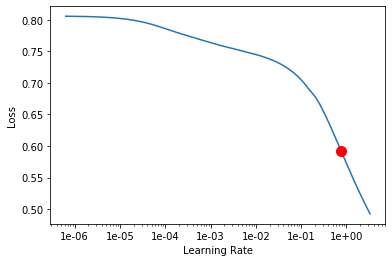

In [31]:
!rm models/bestmodel.pth
learner.lr_find()
learner.recorder.plot(suggestion=True)


In [ ]:
learner.fit_fc(1, 4e-1)

epoch,train_loss,valid_loss,time


In [ ]:
learner.save('1k-3epochs-0.011183')

In [ ]:
p = learner.get_preds(DatasetType.Valid)

In [ ]:
for batch_idx, batch in progress_bar(
    enumerate(learner.dl(DatasetType.Train)), total=len(learner.dl(DatasetType.Train))):
    p = learner.pred_batch(DatasetType.Train, batch=batch)
    break

In [ ]:
p[0]

In [ ]:
for i in range(200): print(torch.argmax(p[0][i]))

In [ ]:
torch.sigmoid(p[23][0])

In [ ]:
p

In [ ]:
p[0].shape

In [ ]:
p[0].shape

In [ ]:
torch.sigmoid(p[1])

In [ ]:
np.where(torch.sigmoid(p[1])>=0.5)

In [ ]:
data.valid_ds